In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils, localizer


2024-02-04 16:01:50.911283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 16:01:50.911361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 16:01:50.912430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 16:01:50.920499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 16:01:51.922622: W tensorflow/compiler/tf2

In [2]:
# model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')
# model_ew.save('models/ew_localizer.hdf5')


In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2_custom/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:40]}

In [4]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

ew_input_features = input_features_reduced#['Eccentricity', 'Semimajor Axis (m)', 'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)']
#ew_input_features = ['Eccentricity', 'Longitude (deg)', 'Latitude (deg)']

ns_input_features = input_features_reduced#['Eccentricity', 'Semimajor Axis (m)',  'Inclination (deg)', 'Latitude (deg)', 'Longitude (deg)']


utils.set_random_seed(42)
ds_gen_ew = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ew_input_features,
                                      with_labels=True, pad_location_labels=0,
                                      nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0],
                                      train_val_split=0.8, input_stride=2, padding='none',
                                      transform_features=True,
                                      scale=True,
                                      per_object_scaling=True,
                                      input_history_steps=64, input_future_steps=24, seed=69)

# ds_gen_ns = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ns_input_features,
#                                       with_labels=True, pad_location_labels=0,
#                                       nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0],
#                                       train_val_split=0.8, input_stride=4, padding='none',
#                                       transform_features=True,
#                                       scale=True,
#                                       per_object_scaling=True,
#                                       input_history_steps=64, input_future_steps=24, seed=69)

=========================Creating Generator=======================
Seed: 69
nTrain: 1360 nVal: 340 (0.80)
Padding: none
Scaling: True  (per-object)
Horizons: 64-24 @ stride 2
Sin-Transformed features: ['True Anomaly (deg)', 'Argument of Periapsis (deg)']
Padding node locations in non-binary fashion ([24.0, 34.0, 49.0, 70.0, 100.0, 70.0, 49.0, 34.0, 24.0])
=========================Finished Generator=======================


In [ ]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True, stride=1)

print(train_ew.element_spec)

#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,32],[32,16]], dense_layers=[64,32], l2_reg=0.0001, mixed_dropout=0.1, lr_scheduler=[30000,0.8], seed=0)
model_ew = prediction_models.Dense_NN(val_ew, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#model_ew = prediction_models.LSTM_NN(val_ew, input_dropout=0.0, mixed_dropout=0.1, lstm_layers=[128,64], dense_layers=[32,16], l2_reg=0.0001, lr_scheduler=[], seed=1)

train_ew = train_ew.map(lambda x,y:(x,y['EW_Node_Location']))
val_ew = val_ew.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=20, verbose=1, plot_hist=True, 
                    class_weight={0: 1.0, 1: 2.0}, 
                    callbacks=[])
#model_ew.model.save('models/ew_localizer.hdf5')

2024-02-04 16:03:01.655720: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 16:03:01.677691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 16:03:01.677767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 16:03:01.679750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 16:03:01.679823: I external/local_xla/xla/stream_executor

(TensorSpec(shape=(None, 44, 9), dtype=tf.float64, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 44, 9)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 32)            2624      
                                                                 
 activation (Activation)     (None, 36, 32)            0         
                                                                 
 dropout (Dropout)           (None, 36, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 32)            6176      
                                                                 
 activation_1 (Activation)   (None, 31, 32)      

2024-02-04 16:03:08.863424: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1181106432 exceeds 10% of free system memory.


Epoch 1/35


2024-02-04 16:03:11.403212: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-04 16:03:12.858210: I external/local_xla/xla/service/service.cc:168] XLA service 0xa18c2d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-04 16:03:12.858264: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-04 16:03:12.865075: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707058992.965062   15943 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


729/729 [==============================] - 15s 13ms/step - loss: 79.5879 - mse: 79.5879 - mae: 2.6386 - val_loss: 56.6283 - val_mse: 56.6283 - val_mae: 1.9768
Epoch 2/35
729/729 [==============================] - 9s 12ms/step - loss: 50.1090 - mse: 50.1090 - mae: 1.8483 - val_loss: 42.6707 - val_mse: 42.6707 - val_mae: 1.6779
Epoch 3/35
729/729 [==============================] - 8s 11ms/step - loss: 41.5846 - mse: 41.5846 - mae: 1.6368 - val_loss: 37.8849 - val_mse: 37.8849 - val_mae: 1.4369
Epoch 4/35
729/729 [==============================] - 9s 12ms/step - loss: 36.7668 - mse: 36.7668 - mae: 1.4866 - val_loss: 34.1370 - val_mse: 34.1370 - val_mae: 1.2750
Epoch 5/35
729/729 [==============================] - 9s 12ms/step - loss: 34.3754 - mse: 34.3754 - mae: 1.4089 - val_loss: 32.5113 - val_mse: 32.5113 - val_mae: 1.2511
Epoch 6/35
729/729 [==============================] - 9s 12ms/step - loss: 32.8161 - mse: 32.8161 - mae: 1.3827 - val_loss: 31.3319 - val_mse: 31.3319 - val_mae: 1.2

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


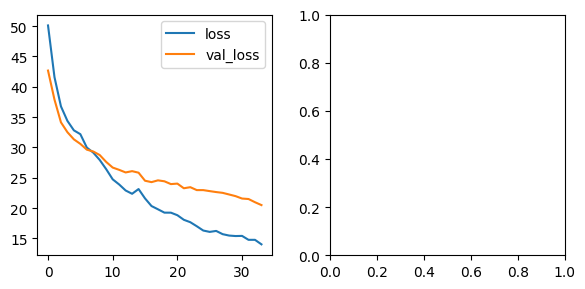

In [5]:
train_ew, val_ew = ds_gen_ew.get_datasets(512,
                                          label_features=['EW_Node_Location_nb'],
                                          shuffle=True,
                                          stride=1,
                                          keep_label_stride=8)
print(train_ew.element_spec)

model_ew = prediction_models.Dense_NN_regression(val_ew,
                                                 conv1d_layers=[[32,9],[32,6],[32,3]], 
                                                 dense_layers=[32,16],
                                                 l2_reg=0.000,
                                                 mixed_dropout_dense=0.25,
                                                 mixed_dropout_cnn=0.2,
                                                 lr_scheduler=[0.001,7500,0.9],
                                                 final_activation='linear',
                                                 seed=0)

model_ew.summary()
# TODO: seed and dropout have a very strong impact on wether the model is able to learn at all
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=35, verbose=1, plot_hist=True, callbacks=[])


2024-02-04 15:09:02.341969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 15:09:02.366745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 15:09:02.366838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 15:09:02.369422: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 15:09:02.369628: I external/local_xla/xla/stream_executor

(TensorSpec(shape=(None, 22, 9), dtype=tf.float64, name=None), {'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 22, 9)]           0         
                                                                 
 conv1d (Conv1D)             (None, 17, 32)            1760      
                                                                 
 activation (Activation)     (None, 17, 32)            0         
                                                                 
 dropout (Dropout)           (None, 17, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            6176      
                                                                 
 activation_1 (Activation)   (None, 12, 32)        

2024-02-04 15:09:11.330728: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-04 15:09:12.721804: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fadac01ac70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-04 15:09:12.721854: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-04 15:09:12.729356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707055752.835048   96938 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 [==============================] - 15s 13ms/step - loss: 96.1624 - mse: 96.1624 - mae: 3.0446 - val_loss: 81.8442 - val_mse: 81.8442 - val_mae: 3.1634
Epoch 2/40
718/718 [==============================] - 7s 10ms/step - loss: 72.3671 - mse: 72.3671 - mae: 2.2499 - val_loss: 72.4639 - val_mse: 72.4639 - val_mae: 2.5551
Epoch 3/40
718/718 [==============================] - 7s 10ms/step - loss: 66.6139 - mse: 66.6139 - mae: 2.0927 - val_loss: 68.2699 - val_mse: 68.2699 - val_mae: 2.1160
Epoch 4/40
718/718 [==============================] - 7s 10ms/step - loss: 62.4774 - mse: 62.4774 - mae: 2.0406 - val_loss: 64.7594 - val_mse: 64.7594 - val_mae: 1.8726
Epoch 5/40
718/718 [==============================] - 8s 11ms/step - loss: 59.5677 - mse: 59.5677 - mae: 1.9831 - val_loss: 62.0954 - val_mse: 62.0954 - val_mae: 1.7519
Epoch 6/40
718/718 [==============================] - 8s 11ms/step - loss: 57.1655 - mse: 57.1655 - mae: 1.9160 - val_loss: 60.7002 - val_mse: 60.7002 - val_mae: 1.6

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


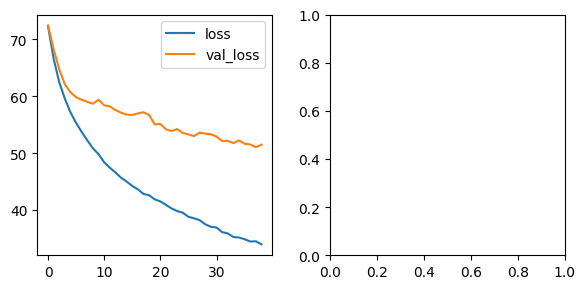

In [5]:
train_ns, val_ns = ds_gen_ns.get_datasets(512,
                                          label_features=['NS_Node_Location_nb'],
                                          shuffle=True,
                                          stride=1,
                                          keep_label_stride=8)
print(train_ns.element_spec)

model_ns = prediction_models.Dense_NN_regression(val_ns, 
                                                 conv1d_layers=[[32,6],[32,6]], 
                                                 dense_layers=[32,16],
                                                 l2_reg=0.0, 
                                                 mixed_dropout_dense=0.25,
                                                 mixed_dropout_cnn=0.2,
                                                 lr_scheduler=[0.001,7500,0.9],
                                                 final_activation='linear',
                                                 seed=0)

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=40, verbose=1, plot_hist=True, callbacks=[])


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location_nb'], shuffle=True, stride=1)
model_ns = prediction_models.Dense_NN_regression(val_ns, conv1d_layers=[[32,6],[32,6]], dense_layers=[16,4],
                                                 l2_reg=0.0, mixed_dropout=0.2,
                                                 lr_scheduler=[0.002,15000,0.9],
                                                 final_activation='relu',
                                                 seed=0)
model_ns.load_model('submission/models/ns_localizer_cnn.hdf5')
model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=10, verbose=1, plot_hist=True, callbacks=[])

Starting training. Optimizing "val_accuracy"
Epoch 1/10
  1/715 [..............................] - ETA: 12s - loss: 50.7690 - mse: 50.7690 - mae: 1.1895

715/715 [==============================] - 7s 10ms/step - loss: 46.3722 - mse: 46.3722 - mae: 1.6806 - val_loss: 54.1683 - val_mse: 54.1683 - val_mae: 1.7771
Epoch 2/10
715/715 [==============================] - 7s 9ms/step - loss: 45.6383 - mse: 45.6383 - mae: 1.6664 - val_loss: 54.3597 - val_mse: 54.3597 - val_mae: 1.8099
Epoch 3/10
715/715 [==============================] - 7s 9ms/step - loss: 45.5111 - mse: 45.5111 - mae: 1.6614 - val_loss: 54.3226 - val_mse: 54.3226 - val_mae: 1.8086
Epoch 4/10
715/715 [==============================] - 7s 9ms/step - loss: 45.3528 - mse: 45.3528 - mae: 1.6580 - val_loss: 54.3298 - val_mse: 54.3298 - val_mae: 1.8084
Epoch 5/10
715/715 [==============================] - 7s 10ms/step - loss: 44.9777 - mse: 44.9777 - mae: 1.6475 - val_loss: 54.0860 - val_mse: 54.0860 - val_mae: 1.7931
Epoch 6/10
715/715 [==============================] - 7s 10ms/step - loss: 44.8075 - mse: 44.8075 - mae: 1.6441 - val_loss: 53.9927 - val_mse: 53.9927 - val_mae: 1.7917


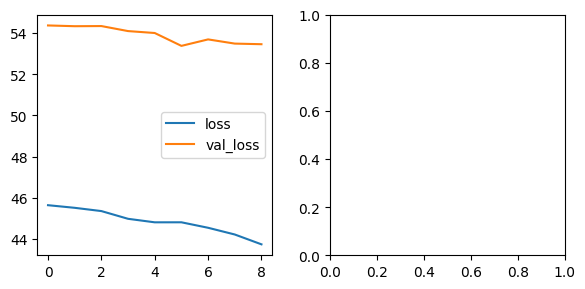

In [10]:
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=10, verbose=1, plot_hist=True, callbacks=[])

Starting training. Optimizing "val_accuracy"
Epoch 1/10
729/729 [==============================] - 9s 13ms/step - loss: 13.5904 - mse: 13.5904 - mae: 0.7398 - val_loss: 20.5485 - val_mse: 20.5485 - val_mae: 0.7818
Epoch 2/10
729/729 [==============================] - 9s 12ms/step - loss: 13.6703 - mse: 13.6703 - mae: 0.7519 - val_loss: 21.1806 - val_mse: 21.1806 - val_mae: 0.7810
Epoch 3/10
729/729 [==============================] - 8s 11ms/step - loss: 13.7083 - mse: 13.7083 - mae: 0.7430 - val_loss: 21.0575 - val_mse: 21.0575 - val_mae: 0.8042
Epoch 4/10
729/729 [==============================] - 8s 12ms/step - loss: 13.5074 - mse: 13.5074 - mae: 0.7429 - val_loss: 20.3689 - val_mse: 20.3689 - val_mae: 0.7591
Epoch 5/10
729/729 [==============================] - 8s 11ms/step - loss: 13.3225 - mse: 13.3225 - mae: 0.7266 - val_loss: 20.0615 - val_mse: 20.0615 - val_mae: 0.7890
Epoch 6/10
729/729 [==============================] - 8s 11ms/step - loss: 12.6429 - mse: 12.6429 - mae: 0.708

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


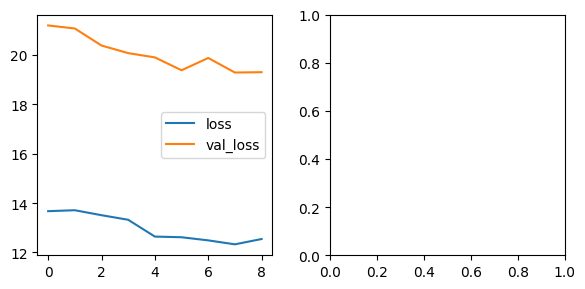

In [29]:
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=10, verbose=1, plot_hist=True, callbacks=[])

In [23]:
model_ew.model.save('submission/models/ew_localizer_cnn.hdf5')
#pickle.dump(ds_gen_ew.scaler, open('submission/models/EW_localizer_scaler_cnn.pkl', 'wb'))

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
print(model_ns.model.optimizer.learning_rate)

<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.0045>


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True, stride=1)

model_ns = prediction_models.Dense_NN(train_ns, conv1d_layers=[], dense_layers=[256, 128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
train_ns = train_ns.map(lambda x,y:(x,y['NS_Node_Location']))
val_ns = val_ns.map(lambda x,y:(x,y['NS_Node_Location'])) # temporary fix to allow class weights

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=False, class_weight={0: 0.5, 1: 20.0}, callbacks=[])
model_ns.model.save('models/ns_localizer.hdf5')

model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [12]:
model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')


In [ ]:
model_ew = tf.keras.models.load_model('submission/models/ew_localizer_cnn.hdf5')


In [30]:
object_limit = None
direction = 'EW'

preds_df = localizer.create_prediction_df(ds_gen=ds_gen_ew,
                                model=model_ew,
                                train=False,
                                test=False,
                                output_dirs=[direction],
                                object_limit=object_limit,
                                prediction_batches=3,
                                verbose=1)

7305/7305 [==============================] - 24s 3ms/step
(709440, 2)
(709440, 1)


In [34]:
subm_df = localizer.postprocess_predictions(preds_df=preds_df,
                                            dirs=[direction],
                                            threshold=65.0,
                                            add_initial_node=True,
                                            clean_consecutives=True)

evaluator, sub_df = localizer.evaluate_localizer(subm_df=subm_df,
                                                 gt_path=challenge_data_dir / 'train_labels.csv',
                                                 object_ids=list(map(int, ds_gen_ew.val_keys))[:object_limit],
                                                 dirs=[direction],
                                                 with_initial_node=False,
                                                 return_scores=False,
                                                 verbose=1)

# EW after 40 epochs:
# 50: TP: 600 FP: 75 FN: 57
# 55: TP: 596 FP: 66 FN: 61
# 60: TP: 593 FP: 53 FN: 64
# 65: TP: 586 FP: 45 FN: 71

# NS after 45 epochs:
# TODO: for NS, ID nodes are clearly the most difficult
# 50: TP: 264 FP: 136 FN: 151
# 55: TP: 258 FP: 103 FN: 157
# 60: TP: 248 FP: 76 FN: 167
# 65: TP: 234 FP: 63 FN: 181


Evaluator ignoring classifications
Precision: 0.93
Recall: 0.89
F2: 0.90
RMSE: 1.125
TP: 586 FP: 45 FN: 71


In [ ]:
localizer.plot_prediction_curve(ds_gen=ds_gen_ew,
                                model=model_ew,
                                label_features=['EW_Node_Location_nb'],
                                object_ids=ds_gen_ew.val_keys[10:20],
                                zoom=True)